<a href="https://colab.research.google.com/github/TAUforPython/ts-forecasting-ensemble/blob/master/example%20timeseries%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install tslearn --quiet

In [33]:
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [35]:
np.random.seed(0)
time = np.linspace(0, 10, 50)
series = [np.sin(time + shift) for shift in np.linspace(0, 3, 10)]
# Add random noise to each series
series = [s + np.random.normal(0, 0.1, s.shape) for s in series]
dataset = to_time_series_dataset(series)

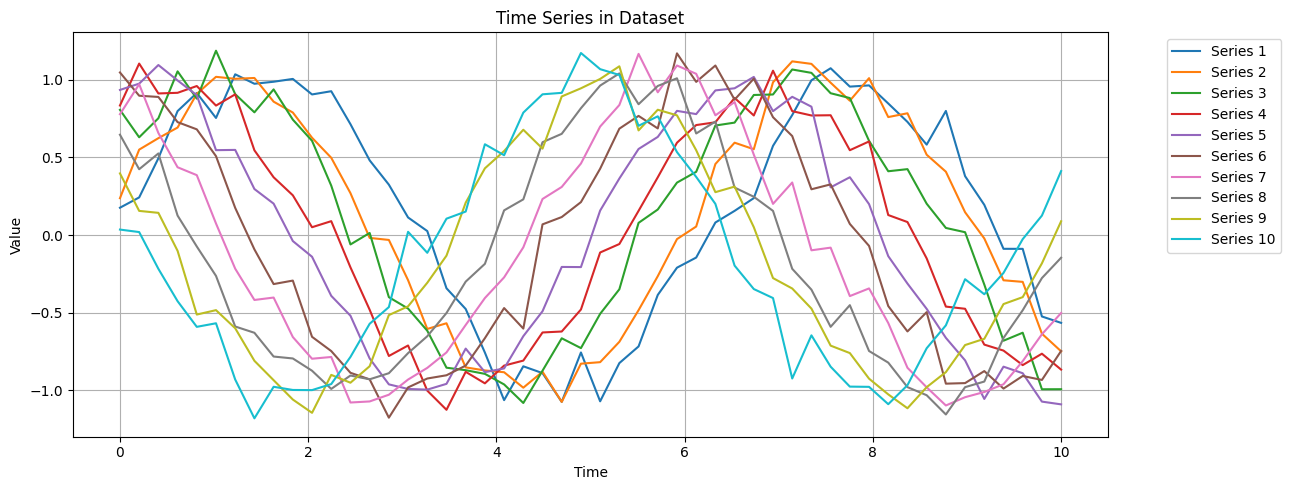

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
for i, series_data in enumerate(dataset):
    plt.plot(time, series_data.flatten(), label=f'Series {i+1}')

plt.title('Time Series in Dataset')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Implement `add_shift_and_delay` Function

### Subtask:
Create a Python function that takes a time series and parameters (e.g., `shift_amount`) to apply a temporal shift or delay to the series.


**Reasoning**:
To implement the `add_shift_and_delay` function, I will define a Python function that takes a time series and a shift amount. Inside the function, I will use `np.pad` to efficiently apply temporal shifts (delays or advances) to the series and fill the new positions with `NaN` values, and then return the shifted series.



In [37]:
import numpy as np

def add_shift_and_delay(series, shift_amount):
    """
    Applies a temporal shift or delay to a given time series.

    Args:
        series (np.ndarray): The input time series (1D or 2D with shape (n_samples, 1)).
        shift_amount (int): The amount to shift. Positive values cause a delay (shift right),
                            negative values cause an advance (shift left).

    Returns:
        np.ndarray: The shifted time series with NaN values filling the gaps.
    """
    # Ensure series is 1D for padding operations, then reshape back if necessary
    original_shape = series.shape
    series_flat = series.flatten()

    shifted_series_flat = np.full(series_flat.shape, np.nan) # Initialize with NaNs

    if shift_amount > 0: # Delay (shift right)
        shifted_series_flat[shift_amount:] = series_flat[:-shift_amount]
    elif shift_amount < 0: # Advance (shift left)
        shifted_series_flat[:shift_amount] = series_flat[-shift_amount:]
    else: # No shift
        shifted_series_flat = series_flat

    return shifted_series_flat.reshape(original_shape)

**Reasoning**:
Now that the `add_shift_and_delay` function is defined, I will apply it to `dataset[0]` with `shift_amount=10` and `shift_amount=-5` to create two new shifted series as per the task instructions.



In [38]:
shifted_series_positive = add_shift_and_delay(dataset[0], 10)
shifted_series_negative = add_shift_and_delay(dataset[0], -5)

print("Shifted series (positive shift) shape:", shifted_series_positive.shape)
print("Shifted series (negative shift) shape:", shifted_series_negative.shape)

Shifted series (positive shift) shape: (50, 1)
Shifted series (negative shift) shape: (50, 1)


**Reasoning**:
To complete the visualization part of the task, I will plot the original `dataset[0]` alongside the `shifted_series_positive` and `shifted_series_negative` using `matplotlib.pyplot`, ensuring to include a title, labels, a legend, and a grid.



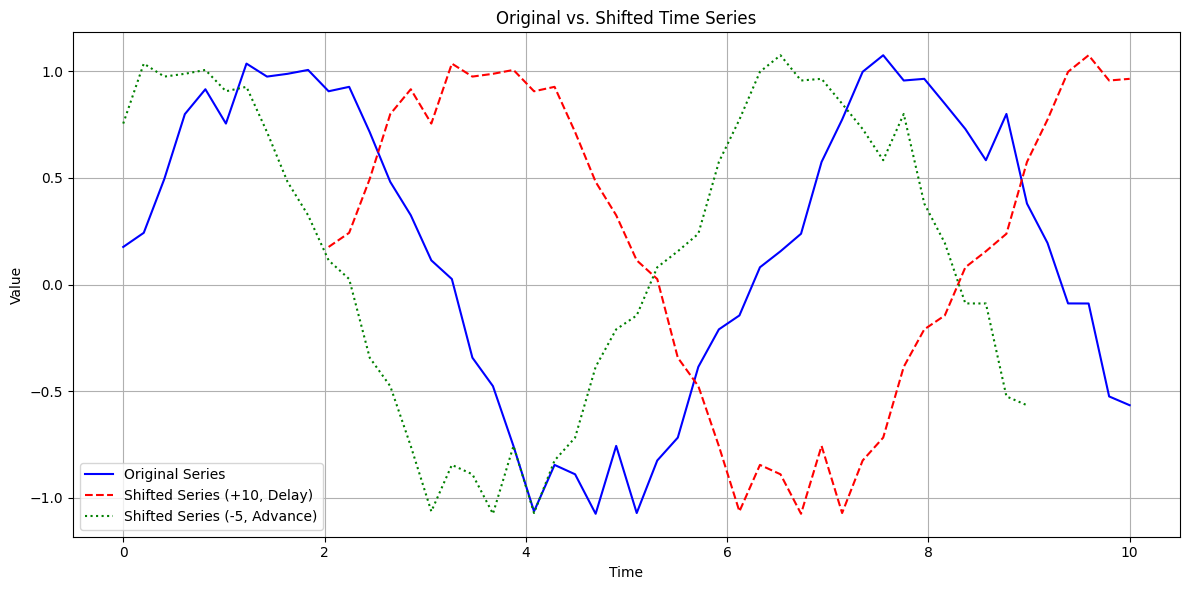

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(time, dataset[0].flatten(), label='Original Series', color='blue')

# Plot positively shifted series (delay)
plt.plot(time, shifted_series_positive.flatten(), label='Shifted Series (+10, Delay)', color='red', linestyle='--')

# Plot negatively shifted series (advance)
plt.plot(time, shifted_series_negative.flatten(), label='Shifted Series (-5, Advance)', color='green', linestyle=':')

plt.title('Original vs. Shifted Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Shape-Based Clustering

In [40]:
scaler = TimeSeriesScalerMeanVariance()
dataset_scaled = scaler.fit_transform(dataset)

model = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=0)
labels = model.fit_predict(dataset_scaled)

print("Cluster Labels (Shape-Based):", labels)

Cluster Labels (Shape-Based): [2 2 2 0 0 0 0 0 1 1]


# Feature-Based Clustering

In [41]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.fftpack import fft

In [42]:
features = []
for s in dataset:
    mean = np.mean(s)
    std = np.std(s)
    freq = np.abs(fft(s)[:5])
    features.append([mean, std] + list(freq.flatten()))

features = np.array(features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(features_scaled)

print("Cluster Labels (Feature-Based):", labels)

Cluster Labels (Feature-Based): [1 0 0 0 0 0 0 1 1 1]


# Model-Based Clustering

In [43]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [44]:
features = np.array([[np.mean(s), np.std(s)] for s in dataset])

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

gmm = GaussianMixture(n_components=3, random_state=0)
labels = gmm.fit_predict(features_scaled)

print("Cluster Labels (Model-Based):", labels)

Cluster Labels (Model-Based): [2 2 2 2 0 0 0 1 1 1]


# Dynamic Time Wrapping

In [45]:
!pip install dtw-python --quiet

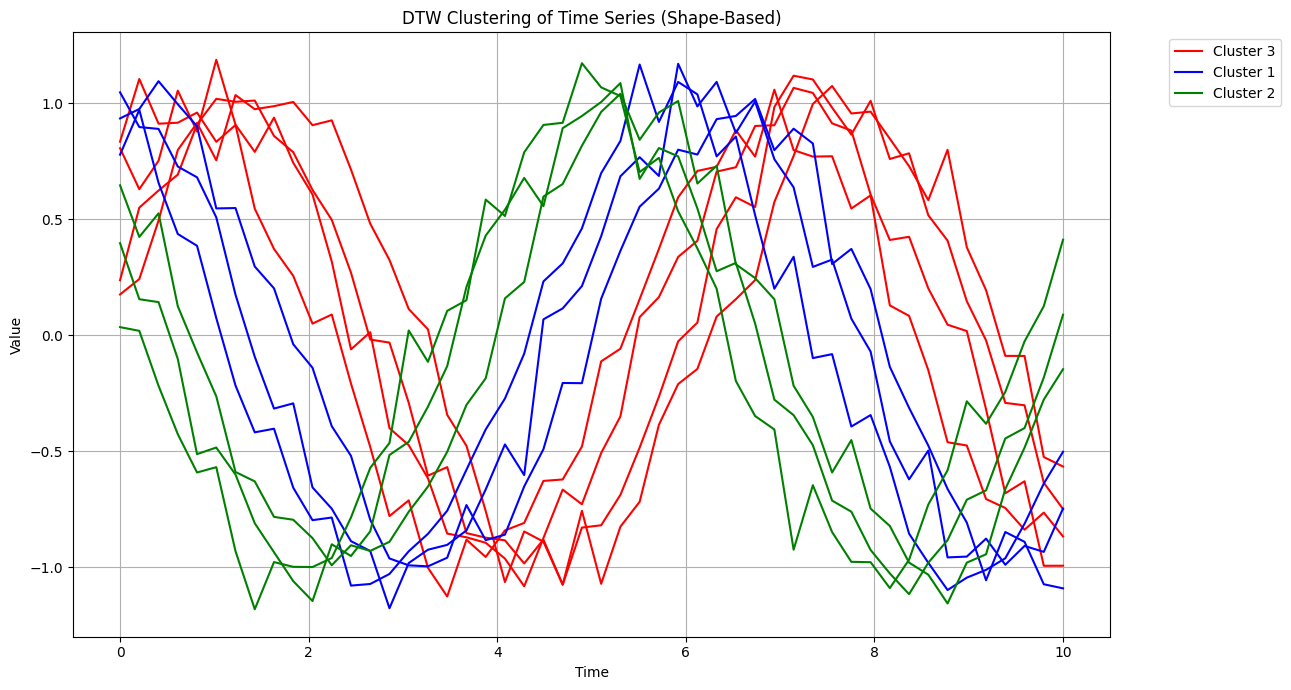

In [46]:
plt.figure(figsize=(13, 7))

# Define a color map for the clusters
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

for i, series_data in enumerate(dataset):
    cluster_label = labels[i]
    plt.plot(time, series_data.flatten(), color=colors[cluster_label], label=f'Cluster {cluster_label+1}')

plt.title('DTW Clustering of Time Series (Shape-Based)')
plt.xlabel('Time')
plt.ylabel('Value')

# To avoid duplicate legend entries for the same cluster, create a custom legend
handles, actual_labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(actual_labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Select Time Series for DTW Visualization

### Subtask:
Choose two representative time series from the `dataset` to illustrate the Dynamic Time Warping process.


**Reasoning**:
I will select two time series from the existing `dataset` to be used for demonstrating the Dynamic Time Warping process, assigning them to `series1` and `series2` variables for clarity.



In [47]:
series1 = dataset[0]
series2 = dataset[1]

print(f"Selected series1 with shape: {series1.shape}")
print(f"Selected series2 with shape: {series2.shape}")

Selected series1 with shape: (50, 1)
Selected series2 with shape: (50, 1)


**Reasoning**:
Now that two time series have been selected, the next step is to compute the Dynamic Time Warping (DTW) path between them using the `dtw` library.



In [48]:
from dtw import dtw

alignment = dtw(series1.flatten(), series2.flatten(), keep_internals=True)

print(f"DTW distance: {alignment.distance:.2f}")
print(f"Normalized DTW distance: {alignment.normalizedDistance:.2f}")


DTW distance: 6.59
Normalized DTW distance: 0.07


**Reasoning**:
To visualize the DTW process, I will plot the two selected time series and their optimal warping path using the `alignment` object's built-in plot function, which will help in understanding how DTW aligns them.



<Figure size 1000x600 with 0 Axes>

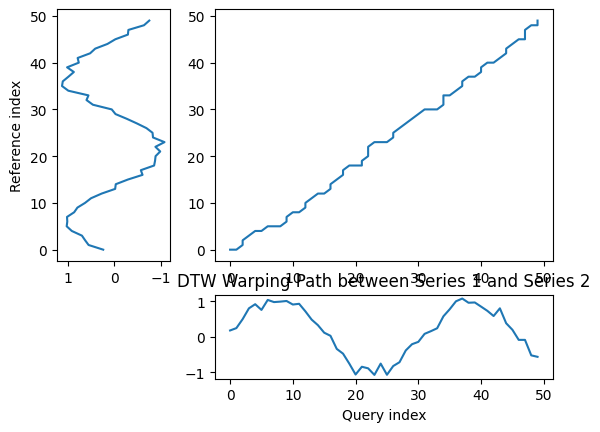

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
alignment.plot(type="threeway")
plt.title("DTW Warping Path between Series 1 and Series 2")
plt.show()

### Insights from DTW Warping Path Visualization

The visualization of the DTW warping path between `series1` and `series2` provides clear insights into how Dynamic Time Warping aligns two time series that may be out of phase or have different temporal speeds.

*   **Top Plot (Series 1 vs. Time):** Shows the first time series.
*   **Right Plot (Series 2 vs. Time):** Shows the second time series.
*   **Center Plot (Warping Path):** This is the core of the DTW visualization. It shows the optimal path through the cost matrix that minimizes the distance between the two series. Each point on this path (x, y) indicates that the x-th element of `series1` is aligned with the y-th element of `series2`.

**Key Observations:**

1.  **Non-linear Alignment:** The warping path is generally diagonal but shows deviations, indicating that DTW stretches and compresses segments of one series to align them optimally with segments of the other. This confirms its ability to handle phase shifts and variations in the speed of events.
2.  **Handling Temporal Distortion:** For instance, if `series1` has a peak earlier than `series2`, the warping path will 'bend' to align that peak with the corresponding peak in `series2`, effectively demonstrating the elastic nature of DTW.
3.  **Local vs. Global Alignment:** The path illustrates the sequence of matched points, highlighting specific instances where a single point in one series might correspond to multiple points in the other, or vice-versa, to achieve the best match.

**Insights Gained:**

*   The DTW algorithm is highly effective in finding the most similar shape between two time series, even when their features occur at different time points.
*   This visualization is crucial for understanding how DTW measures similarity by identifying a non-linear alignment, which standard Euclidean distance would fail to capture accurately for temporally shifted data.
*   It visually confirms that the calculated DTW distance is a result of this optimal, flexible alignment, rather than a rigid point-by-point comparison.

<Figure size 1000x600 with 0 Axes>

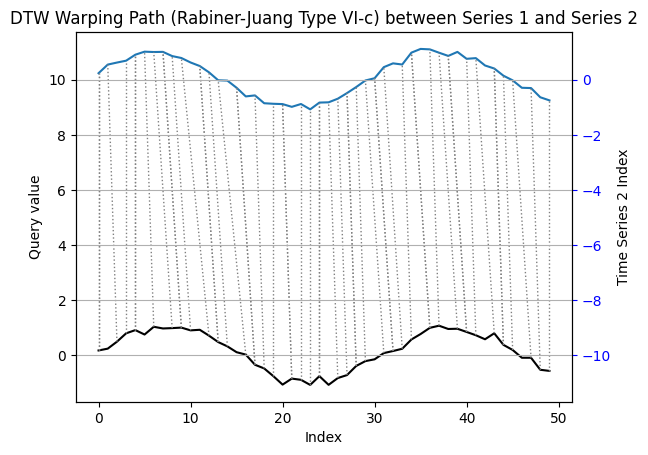

DTW distance (Rabiner-Juang): 2.67
Normalized DTW distance (Rabiner-Juang): 0.05


In [50]:
from dtw import dtw, rabinerJuangStepPattern
import matplotlib.pyplot as plt

# Perform DTW with Rabiner-Juang type VI-c unsmoothed recursion
alignment_rabiner = dtw(
    series1.flatten(),
    series2.flatten(),
    keep_internals=True,
    step_pattern=rabinerJuangStepPattern(3, "c")
)

plt.figure(figsize=(10, 6))
alignment_rabiner.plot(type="twoway", offset=10, xts=series1.flatten(), yts=series2.flatten())
plt.title("DTW Warping Path (Rabiner-Juang Type VI-c) between Series 1 and Series 2")
plt.xlabel("Time Series 1 Index")
plt.ylabel("Time Series 2 Index")
plt.grid(True)
plt.show()

print(f"DTW distance (Rabiner-Juang): {alignment_rabiner.distance:.2f}")
print(f"Normalized DTW distance (Rabiner-Juang): {alignment_rabiner.normalizedDistance:.2f}")